In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV,RepeatedStratifiedKFold
from sklearn import tree

1. pH Value : Suyun asit-baz dengesini gösteren önemli bir parametredir.DSÖ (Dünya Sağlık Örgütü), pH için 6.5 ile 8.5 arasında bir sınır önermektedir.
2. Hardness: Genellikle kalsiyum ve magnezyum tuzlarından kaynaklanır.
3. Solids(Total dissolved solids - TDS ): Su, potasyum, kalsiyum, sodyum, bikarbonatlar, klorürler, magnezyum ve sülfatlar gibi çeşitli inorganik ve bazı organik mineralleri çözebilir. TDS değeri yüksek olan su, yüksek mineral içeriğine sahiptir. İçme suyu için önerilen TDS değeri 500 mg/L olup, maksimum sınır 1000 mg/L’dir.
4. Chloramines: Kamu su sistemlerinde en yaygın kullanılan dezenfektanlardır. Kloraminler, içme suyunu arıtmak için amonyak eklenen klor ile oluşur. İçme suyundaki maksimum güvenli klor seviyesi 4 mg/L (4 ppm) olarak kabul edilir.
5. Sulfate: Doğada minerallerde, toprakta ve kayalarda bulunan bir bileşiktir.Tatlı su kaynaklarında genellikle 3-30 mg/L arasında bulunur, ancak bazı bölgelerde 1000 mg/L’ye kadar çıkabilir
6. Conductivity: Saf su, elektrik akımını iyi iletmez; ancak iyon miktarı arttıkça iletkenlik yükselir.DSÖ’ye göre, suyun iletkenlik değeri 400 μS/cm’yi aşmamalıdır.
7. Organic_carbon: Doğal organik maddelerin (NOM) çürümesiyle veya sentetik kaynaklardan suya karışan organik karbon miktarıdır. ABD Çevre Koruma Ajansı’na (EPA) göre, içme suyundaki toplam organik karbon (TOC) miktarı 2 mg/L’nin altında, arıtma öncesi su için ise 4 mg/L’nin altında olmalıdır.
8. Trihalomethanes:Klorla arıtılan sularda oluşabilen kimyasal bileşiklerdir.İçme suyundaki maksimum güvenli THM seviyesi 80 ppm’dir.
9. Turbidity: Suyun içinde askıda bulunan katı maddelerin miktarına bağlıdır. Suyun ışığı geçirme kapasitesini ölçerek kalitesini belirlemeye yardımcı olur. DSÖ, içme suyu için maksimum bulanıklık değerini 5 NTU olarak önermektedir.
10. Potability: Suyun insan tüketimi için güvenli olup olmadığını gösterir. 1: İçilebilir, 0: İçilemez anlamına gelir.

In [29]:
def load_data():
    data =pd.read_csv(r"water_potability.csv")
    return data
df = load_data()

In [30]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Info #####################")
    print(dataframe.info())
check_df(df)   

##################### Shape #####################
(3276, 10)
##################### Types #####################
ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object
##################### Head #####################
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.3797

Text(0.5, 1.0, 'Su İçilebilirlik Dağılımı')

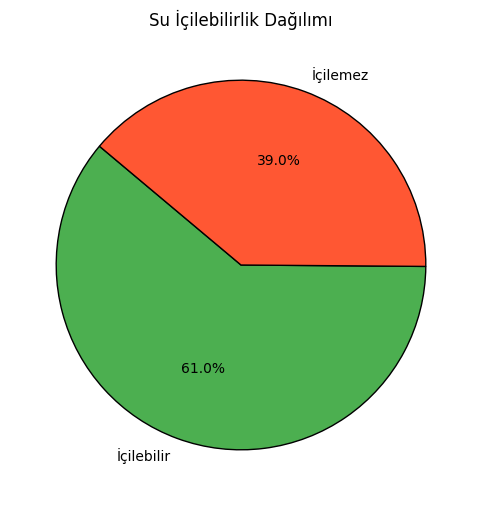

In [31]:
# value count of Potability
counts = df["Potability"].value_counts()

# dependent variable analysis
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=['İçilebilir', 'İçilemez'], autopct='%1.1f%%', 
        colors=['#4CAF50', '#FF5733'], startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Su İçilebilirlik Dağılımı")

In [32]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 3276
Variables: 10
cat_cols: 1
num_cols: 9
cat_but_car: 0
num_but_cat: 1


count    2785.000000
mean        7.080795
std         1.594320
min         0.000000
5%          4.487971
10%         5.106286
20%         5.821618
30%         6.305350
40%         6.702274
50%         7.036752
60%         7.436635
70%         7.841565
80%         8.311493
90%         9.078356
95%         9.789819
99%        10.895339
max        14.000000
Name: ph, dtype: float64


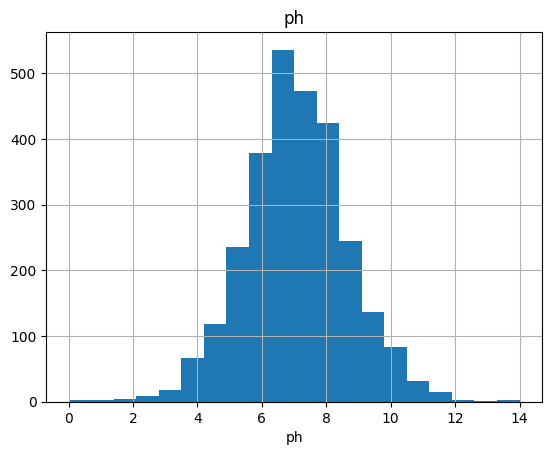

count    3276.000000
mean      196.369496
std        32.879761
min        47.432000
5%        141.763281
10%       155.223964
20%       169.943914
30%       181.382184
40%       189.261418
50%       196.967627
60%       204.123648
70%       212.428038
80%       222.268793
90%       236.350707
95%       249.609769
99%       278.062602
max       323.124000
Name: Hardness, dtype: float64


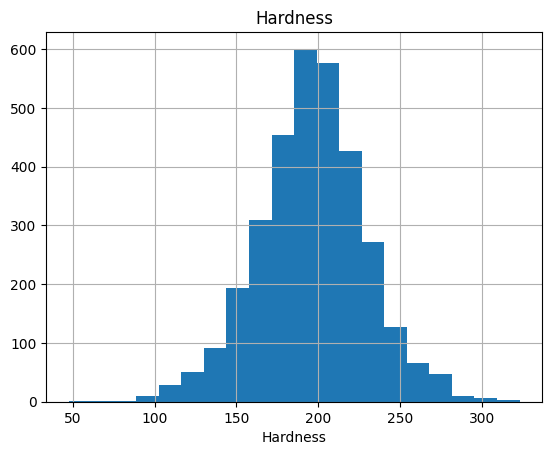

count     3276.000000
mean     22014.092526
std       8768.570828
min        320.942611
5%        9545.812579
10%      11740.528189
20%      14507.017808
30%      16743.033514
40%      18894.852394
50%      20927.833607
60%      23173.319530
70%      25914.944816
80%      28970.087606
90%      33814.935230
95%      38474.990249
99%      45974.106490
max      61227.196008
Name: Solids, dtype: float64


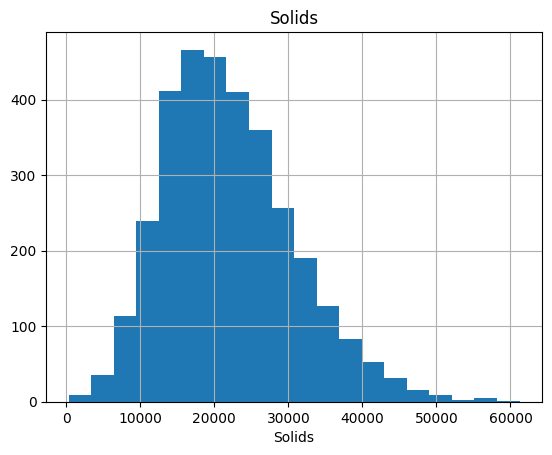

count    3276.000000
mean        7.122277
std         1.583085
min         0.352000
5%          4.503054
10%         5.181271
20%         5.885557
30%         6.338836
40%         6.741909
50%         7.130299
60%         7.493433
70%         7.879549
80%         8.377233
90%         9.122578
95%         9.753101
99%        10.967153
max        13.127000
Name: Chloramines, dtype: float64


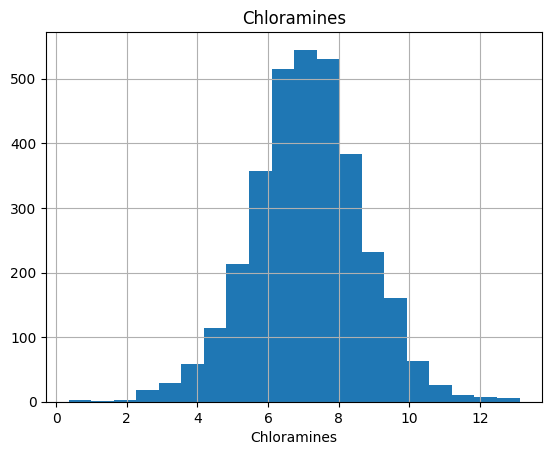

count    2495.000000
mean      333.775777
std        41.416840
min       129.000000
5%        266.616232
10%       283.147302
20%       301.074234
30%       314.052657
40%       323.531021
50%       333.073546
60%       342.094765
70%       353.003114
80%       367.368829
90%       385.966882
95%       403.070190
99%       434.021991
max       481.030642
Name: Sulfate, dtype: float64


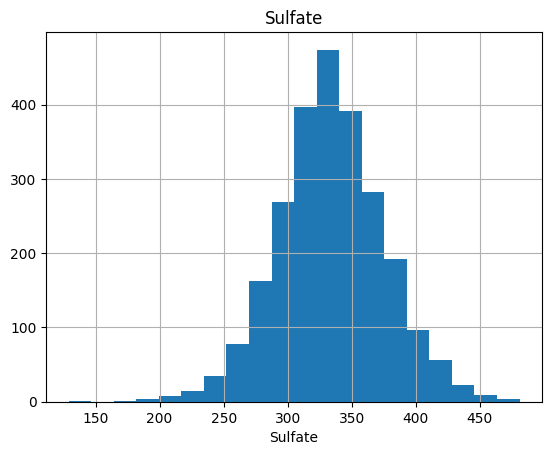

count    3276.000000
mean      426.205111
std        80.824064
min       181.483754
5%        300.109466
10%       325.117124
20%       353.740100
30%       377.682159
40%       399.883388
50%       421.884968
60%       443.570372
70%       470.461610
80%       496.363562
90%       533.297241
95%       566.349320
99%       617.626558
max       753.342620
Name: Conductivity, dtype: float64


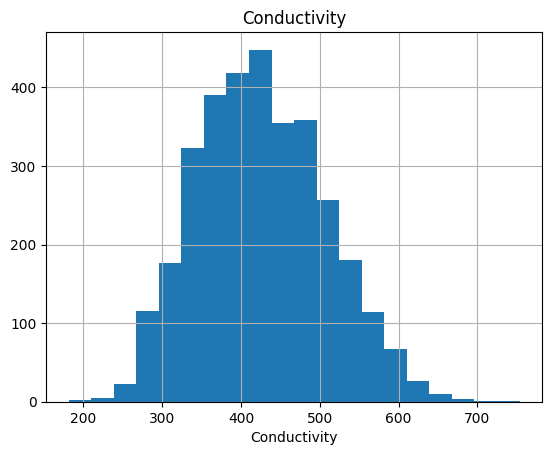

count    3276.000000
mean       14.284970
std         3.308162
min         2.200000
5%          8.815362
10%        10.123765
20%        11.539987
30%        12.507383
40%        13.432557
50%        14.218338
60%        15.101533
70%        16.033136
80%        17.132369
90%        18.504567
95%        19.637254
99%        22.090049
max        28.300000
Name: Organic_carbon, dtype: float64


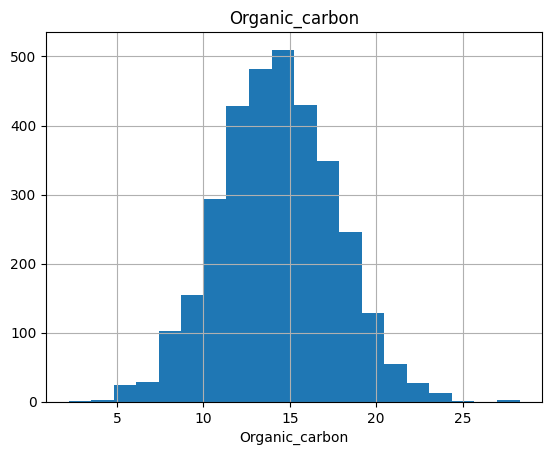

count    3114.000000
mean       66.396293
std        16.175008
min         0.738000
5%         39.552928
10%        45.845615
20%        53.106948
30%        58.690490
40%        62.655857
50%        66.622485
60%        70.446194
70%        74.885950
80%        79.700871
90%        86.491600
95%        92.124059
99%       104.739231
max       124.000000
Name: Trihalomethanes, dtype: float64


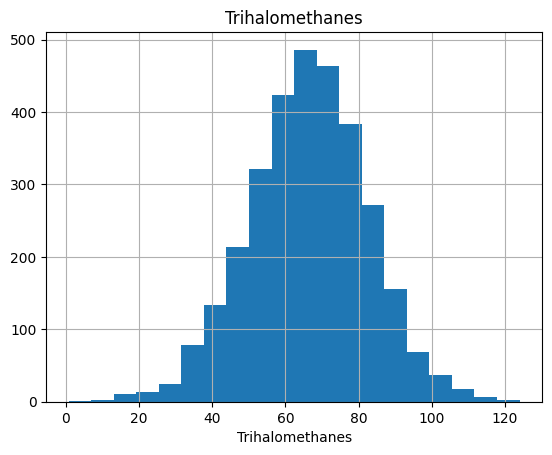

count    3276.000000
mean        3.966786
std         0.780382
min         1.450000
5%          2.684279
10%         2.951803
20%         3.306393
30%         3.557420
40%         3.763906
50%         3.955028
60%         4.168242
70%         4.376925
80%         4.620686
90%         4.977141
95%         5.220925
99%         5.741640
max         6.739000
Name: Turbidity, dtype: float64


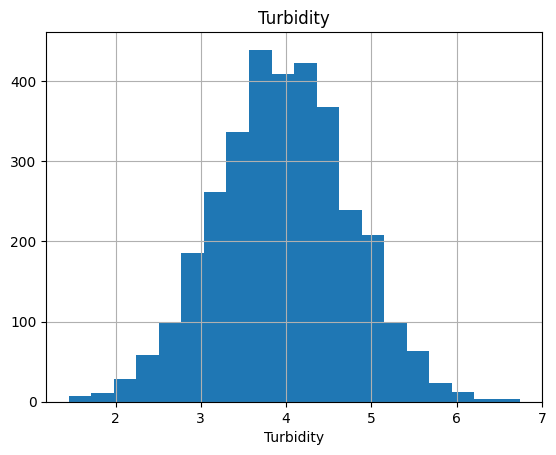

In [33]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)

In [34]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Potability", col)

                  ph
Potability          
0           7.085378
1           7.073783


              Hardness
Potability            
0           196.733292
1           195.800744


                  Solids
Potability              
0           21777.490788
1           22383.991018


            Chloramines
Potability             
0              7.092175
1              7.169338


              Sulfate
Potability           
0           334.56429
1           332.56699


            Conductivity
Potability              
0             426.730454
1             425.383800


            Organic_carbon
Potability                
0                14.364335
1                14.160893


            Trihalomethanes
Potability                 
0                 66.303555
1                 66.539684


            Turbidity
Potability           
0            3.965800
1            3.968328




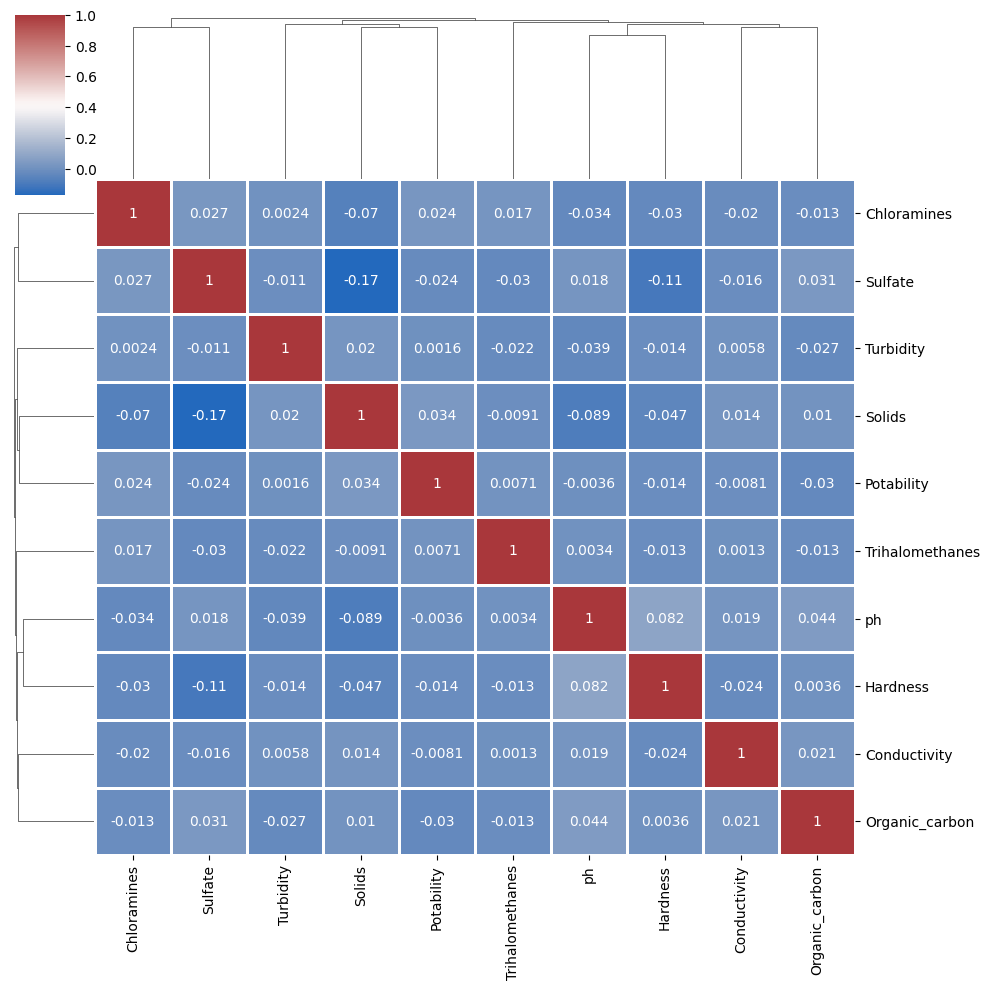

In [35]:
# Correlation Matrix
sns.clustermap(df.corr(),cmap = "vlag",dendrogram_ratio =(0.1,0.2),annot = True, linewidths=0.8, figsize=(10,10))

In [36]:
df.corrwith(df["Potability"]).sort_values(ascending=False)

Potability         1.000000
Solids             0.033743
Chloramines        0.023779
Trihalomethanes    0.007130
Turbidity          0.001581
ph                -0.003556
Conductivity      -0.008128
Hardness          -0.013837
Sulfate           -0.023577
Organic_carbon    -0.030001
dtype: float64

In [37]:
#missing value analysis
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [38]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns
na_columns = missing_values_table(df, na_name=True)        

                 n_miss  ratio
Sulfate             781  23.84
ph                  491  14.99
Trihalomethanes     162   4.95


In [39]:
for col in num_cols:  
    df.loc[df["Potability"] == 0, col] = df.loc[df["Potability"] == 0, col].fillna(df.loc[df["Potability"] == 0, col].median())  
    df.loc[df["Potability"] == 1, col] = df.loc[df["Potability"] == 1, col].fillna(df.loc[df["Potability"] == 1, col].median())

In [40]:
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [41]:
#outlier analysis
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [42]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
for col in num_cols:
    print(check_outlier(df,col))    

False
False
False
False
False
False
False
False
False


In [43]:
#train test split
X = df.drop("Potability",axis = 1).values

y = df["Potability"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [44]:
#min -max normalization 
x_train_max = np.max(X_train)
x_train_min = np.min(X_train)
X_train = (X_train - x_train_min)/(x_train_max - x_train_min)
X_test = (X_test - x_train_min)/(x_train_max - x_train_min)

In [45]:
#Modelling: decision tree and random forest
models =[("DIC", DecisionTreeClassifier(max_depth=3)),
         ("RF", RandomForestClassifier())]

finalresult = [] #score list
cmlist =[] # confusion matrix list

for name,model in models:
    model.fit(X_train,y_train)
    model_result = model.predict(X_test) #prediction

    score = precision_score(y_test,model_result)
    finalresult.append((name,score))

    cm = confusion_matrix(y_test,model_result)
    cmlist.append((name,cm))

In [46]:
finalresult

[('DIC', 0.6310160427807486), ('RF', 0.8)]

In [47]:
cmlist

[('DIC',
  array([[479, 138],
         [130, 236]])),
 ('RF',
  array([[562,  55],
         [146, 220]]))]

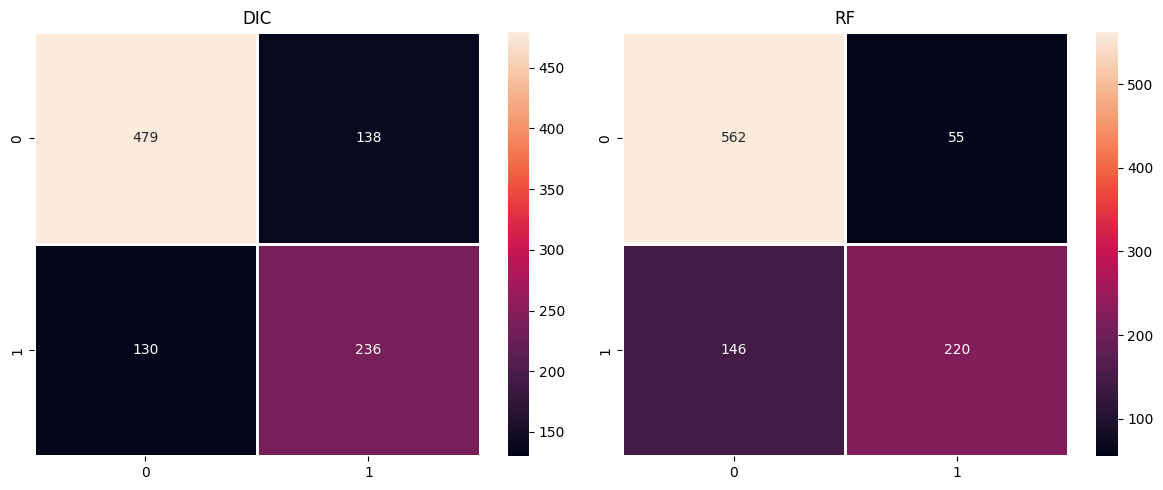

In [48]:
fig, axes = plt.subplots(1, len(cmlist), figsize=(12, 5))  # 1 raw, N columns 

for ax, (name, i) in zip(axes, cmlist):  
    sns.heatmap(i, annot=True, linewidths=0.8, fmt=".0f", ax=ax)  
    ax.set_title(name)  

plt.tight_layout()  

[Text(0.4583333333333333, 0.875, 'Sulfate <= 0.00542\ngini = 0.479083\nsamples = 2293\nvalue = [1381, 912]\nclass = 0'),
 Text(0.25, 0.625, 'Sulfate <= 0.00542\ngini = 0.498422\nsamples = 1068\nvalue = [504, 564]\nclass = 1'),
 Text(0.35416666666666663, 0.75, 'True  '),
 Text(0.16666666666666666, 0.375, 'ph <= 0.000115\ngini = 0.484477\nsamples = 857\nvalue = [504.0, 353.0]\nclass = 0'),
 Text(0.08333333333333333, 0.125, 'gini = 0.402885\nsamples = 447\nvalue = [322, 125]\nclass = 0'),
 Text(0.25, 0.125, 'gini = 0.493706\nsamples = 410\nvalue = [182.0, 228.0]\nclass = 1'),
 Text(0.3333333333333333, 0.375, 'gini = 0.0\nsamples = 211\nvalue = [0, 211]\nclass = 1'),
 Text(0.6666666666666666, 0.625, 'Sulfate <= 0.005464\ngini = 0.406759\nsamples = 1225\nvalue = [877, 348]\nclass = 0'),
 Text(0.5625, 0.75, '  False'),
 Text(0.5, 0.375, 'Sulfate <= 0.005444\ngini = 0.061549\nsamples = 409\nvalue = [396, 13]\nclass = 0'),
 Text(0.4166666666666667, 0.125, 'gini = 0.429688\nsamples = 32\nvalue 

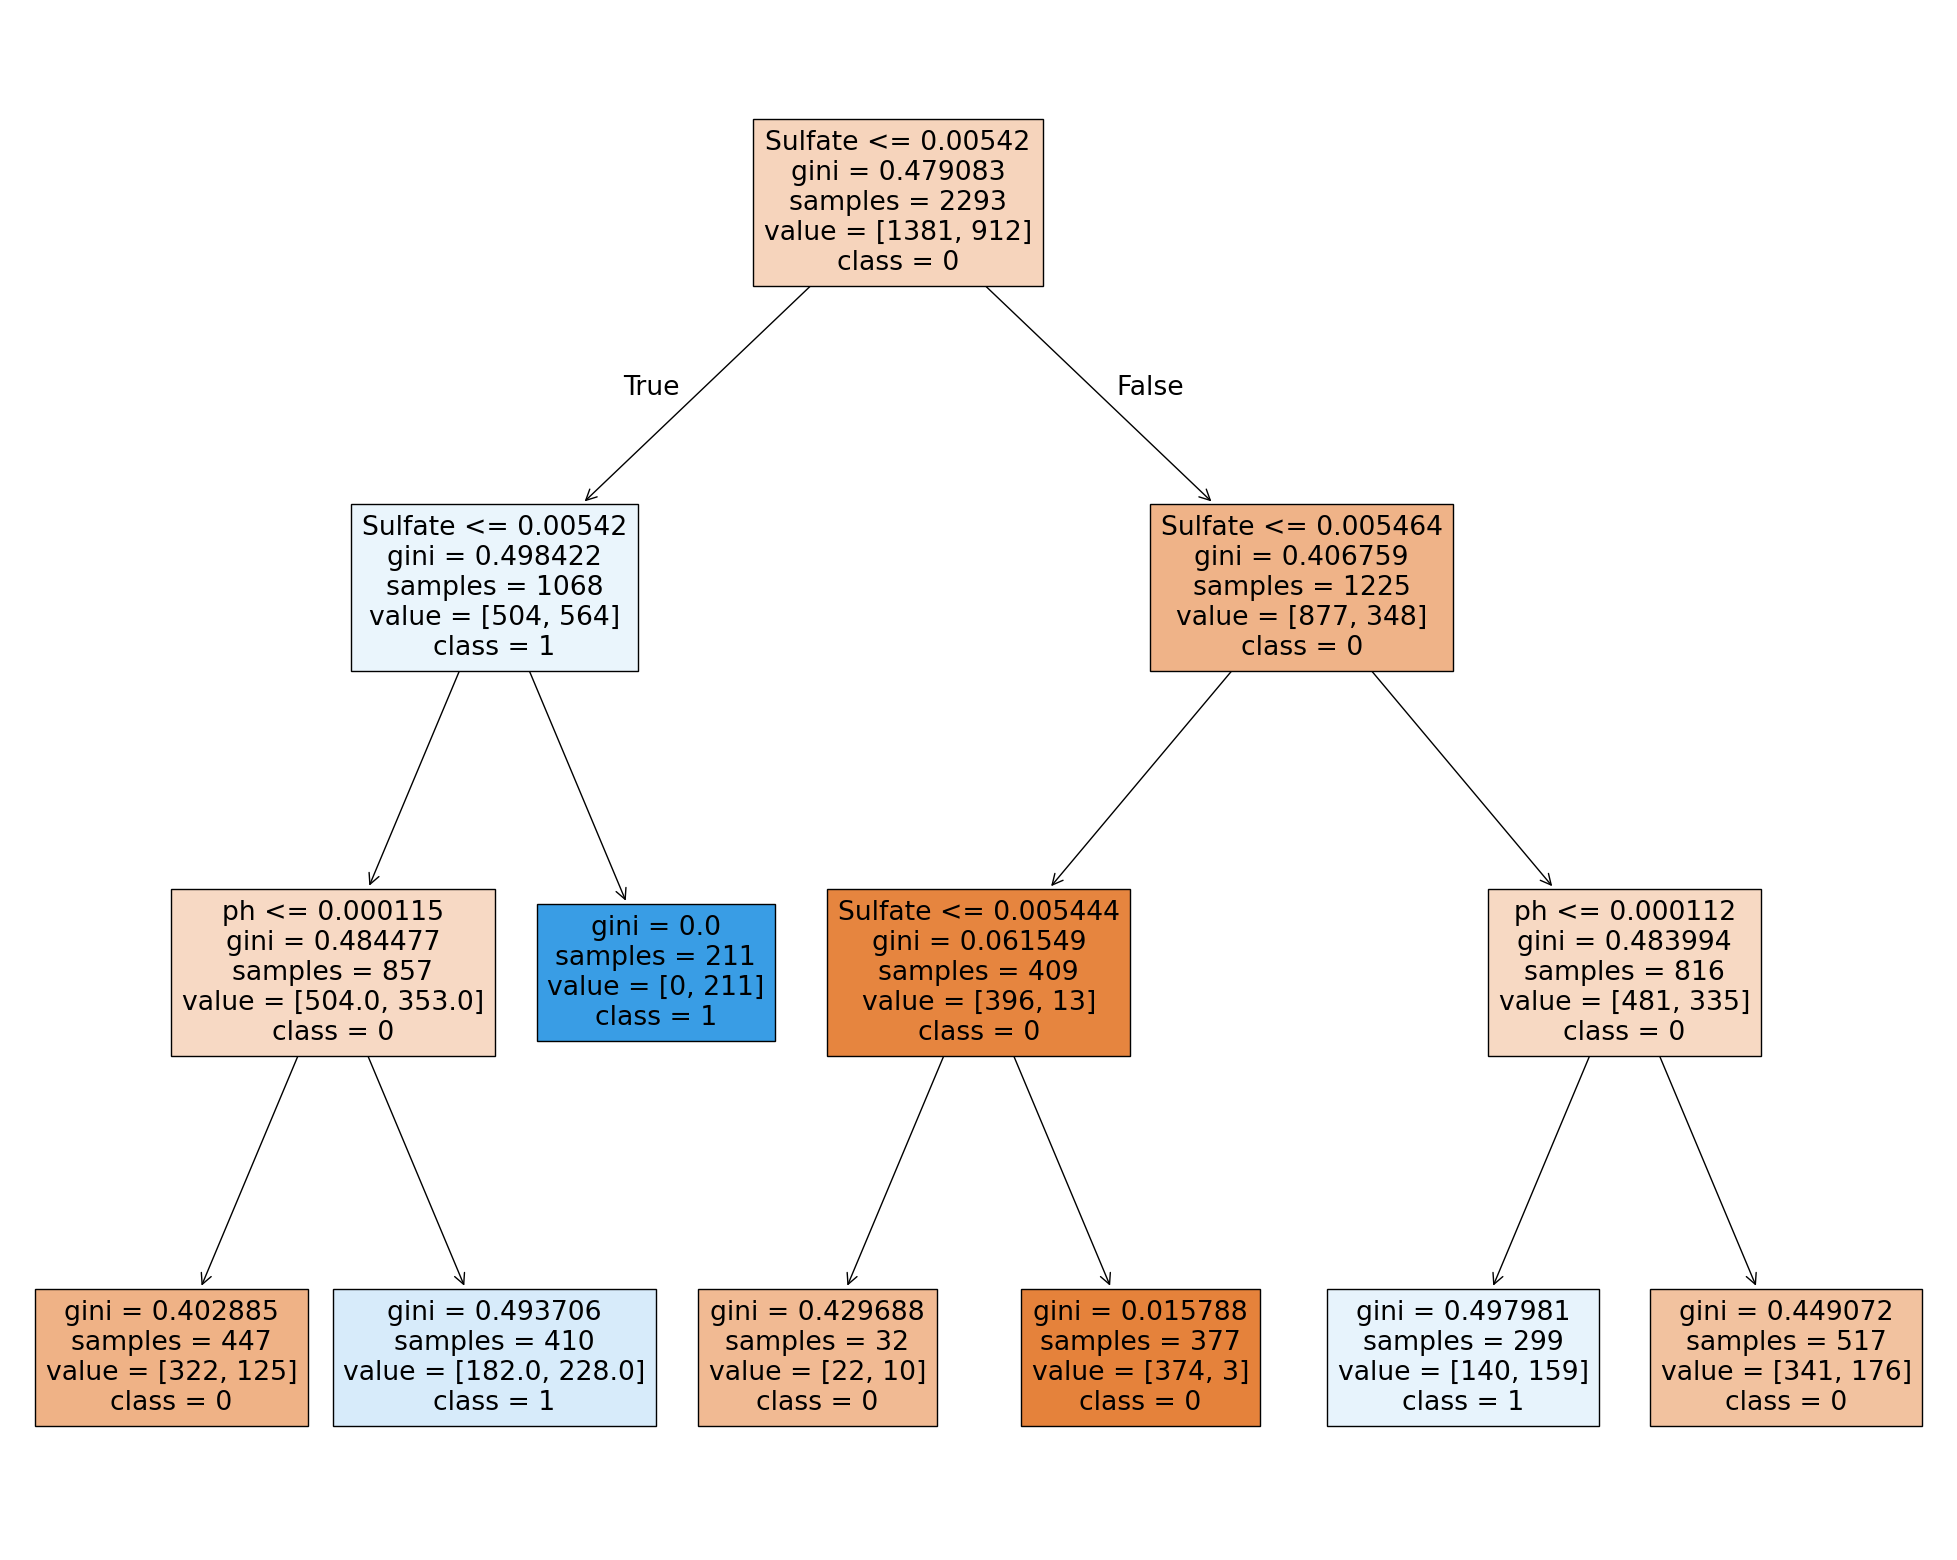

In [49]:
#Evaluation : decision tree visualization
dt_clf = models[0][1]
plt.figure(figsize = (25,20))
tree.plot_tree(dt_clf, feature_names = df.columns.tolist()[:-1],
               class_names = ["0","1"],
               filled = True,
               precision = 6)


In [50]:
#Hyperparameter tuning :random forest
model_params = {
    "Random Forest":
    {
        "model":RandomForestClassifier(),
        "params":
        {
            "n_estimators": [100, 200, 300],
            "max_features": ["sqrt", "log2", None],
            "max_depth": [10, 20, 30, None],
            "min_samples_split": [2, 5, 10]
        }
    }
}    

In [51]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2)
scores = []
for model_name, params in model_params.items():
    rs = RandomizedSearchCV(params["model"],params["params"],cv = cv , n_iter=10)
    rs.fit(X,y)
    scores.append([model_name,dict(rs.best_params_),rs.best_score_])    

In [52]:
scores

[['Random Forest',
  {'n_estimators': 300,
   'min_samples_split': 2,
   'max_features': 'sqrt',
   'max_depth': 30},
  np.float64(0.7956355892757402)]]